In [1]:
import maboss
import ginsim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [24]:
# Setup the name of the files
model_name =  'CRC_model_20230823'

# Visualizing the CRC model

In [3]:
crc_model = ginsim.load(model_name +'.zginml')
ginsim.show(crc_model)

# Load CRC model

We first define all inputs as 0.5 to activate all possible pathway, plus we defining the DNA damage at 0.5 to mimic the process of DNA damage cause by radio/chemotherapy

In [55]:
## Set up the required files
bnd_file = model_name+".bnd"
cfg_WT = model_name+".bnd.cfg"

## Load MaBoSS model
WT = maboss.load(bnd_file, cfg_WT)

## modify the max_time if necessary
## select the variables considered to be internal (not appearing in the resulting csv file) 
## run the model for random initial conditions (defined in the cfg file) or from all 0s initial conditions 

WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':50})
WT_allinputs.update_parameters(sample_count = 1000)
WT_allinputs.update_parameters(thread_count = 10)

## By default, all variables are external (in the cfg file: Node.is_internal = FALSE). 
## If the model is big, the computations may take a very long time.
## We advise to set as external, only the variables that are relevant for the analysis

## if you wish to put some values as internal (the ones that will not be used for the analysis), write (uncomment):
#for name in "ERK_1_2 MK2 p38 Wee1 BRAF CDK1 p21 TP53 Proliferation Senescence Apoptosis".split(' '):
for name in "TAK1 PI3K MTORC2 CDC25A CDK4_6 S6 JNK AKT p38 p21".split(' '):
     WT_allinputs.network[name].is_internal = True

## Put all inputs at random
for i in WT_allinputs.network.names:
    WT_allinputs.network.set_istate(i,[0.5,0.5])

## Set all inputs at 0.5
WT_allinputs.network.set_istate('EGF',[0.5,0.5])
WT_allinputs.network.set_istate('TGFb',[0.5,0.5])
WT_allinputs.network.set_istate('TNF',[0.5,0.5])
WT_allinputs.network.set_istate('Wnt',[0.5,0.5])
WT_allinputs.network.set_istate('IL1R1',[0.5,0.5])
WT_allinputs.network.set_istate('IFNA',[0.5,0.5])
WT_allinputs.network.set_istate('DNA_damage_agent',[1,0])

####WT_allinputs.network.set_istate('GSK3B',[1,0])

## Simulation and visualizing the results
In this part, we set up the outputs of the model, run the simulation and visualizing nodes activity.

### Visualizing the  effect on key cell behavior
We visualize the evolution of key cell behaviors

- Proliferation + Apoptosis + Mitotic_Catastrophe
- DSB and SSB_RS

In [64]:
# Select outputs for visualisation of the results
WT_allinputs.network.set_output(('Proliferation','Apoptosis','Mitotic_Catastrophe',
                                 'DSB','SSB_RS'))

# Define the condition
WT_KRAS = maboss.copy_and_mutate(WT_allinputs, nodes = ['RAS'], mut = 'ON')
WT_BRAF = maboss.copy_and_mutate(WT_allinputs, nodes = ['BRAF'], mut = 'ON')
WT_TP53 = maboss.copy_and_mutate(WT_allinputs, nodes = ['TP53'], mut = 'OFF')

# Run simulations
WT_res = WT_allinputs.run()
WT_KRAS_res = WT_KRAS.run()
WT_BRAF_res = WT_BRAF.run()
WT_TP53_res = WT_TP53.run()

# Mutate CHEK1
WT_allinputs_chek1 = maboss.copy_and_mutate(WT_allinputs, nodes = ['CHEK1','CHEK2'], mut= 'OFF')
WT_KRAS_chek1 = maboss.copy_and_mutate(WT_KRAS, nodes = ['CHEK1','CHEK2'], mut= 'OFF')
WT_BRAF_chek1 = maboss.copy_and_mutate(WT_BRAF, nodes = ['CHEK1','CHEK2'], mut= 'OFF')
WT_TP53_chek1 = maboss.copy_and_mutate(WT_TP53, nodes = ['CHEK1','CHEK2'], mut= 'OFF')

# Run simulations
WT_res_chek1 = WT_allinputs.run()
WT_KRAS_res_chek1 = WT_KRAS_chek1.run()
WT_BRAF_res_chek1 = WT_BRAF_chek1.run()
WT_TP53_res_chek1 = WT_TP53_chek1.run()

['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']


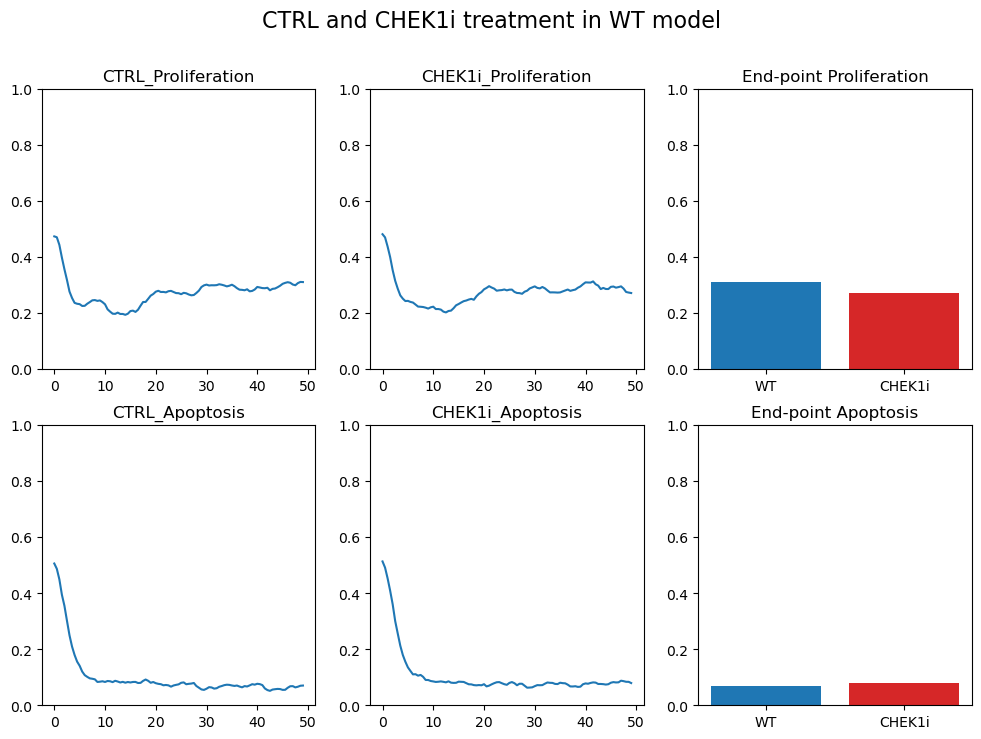

In [65]:
fig, axs = plt.subplots(ncols=3, nrows = 2, figsize=(12, 8))

axs[0][0].plot(WT_res.get_nodes_probtraj().Proliferation)
axs[0][0].set_ylim(0,1)
axs[0][0].title.set_text("CTRL_Proliferation")

axs[0][1].plot(WT_res_chek1.get_nodes_probtraj().Proliferation)
axs[0][1].set_ylim(0,1)
axs[0][1].title.set_text("CHEK1i_Proliferation")

axs[1][0].plot(WT_res.get_nodes_probtraj().Apoptosis)
axs[1][0].set_ylim(0,1)
axs[1][0].title.set_text("CTRL_Apoptosis")

axs[1][1].plot(WT_res_chek1.get_nodes_probtraj().Apoptosis)
axs[1][1].set_ylim(0,1)
axs[1][1].title.set_text("CHEK1i_Apoptosis")

treatment = ['WT','CHEK1i']
value = [WT_res.get_last_nodes_probtraj().Proliferation[0], 
         WT_res_chek1.get_last_nodes_probtraj().Proliferation[0]]
bar_colors = ['tab:blue','tab:red']
axs[0][2].bar(treatment, value, color = bar_colors)
axs[0][2].set_ylim(0,1)
axs[0][2].title.set_text("End-point Proliferation")

value = [WT_res.get_last_nodes_probtraj().Apoptosis[0], 
         WT_res_chek1.get_last_nodes_probtraj().Apoptosis[0]]
axs[1][2].bar(treatment, value, color = bar_colors)
axs[1][2].set_ylim(0,1)
axs[1][2].title.set_text("End-point Apoptosis")


fig.suptitle('CTRL and CHEK1i treatment in WT model', fontsize=16)
plt.show()

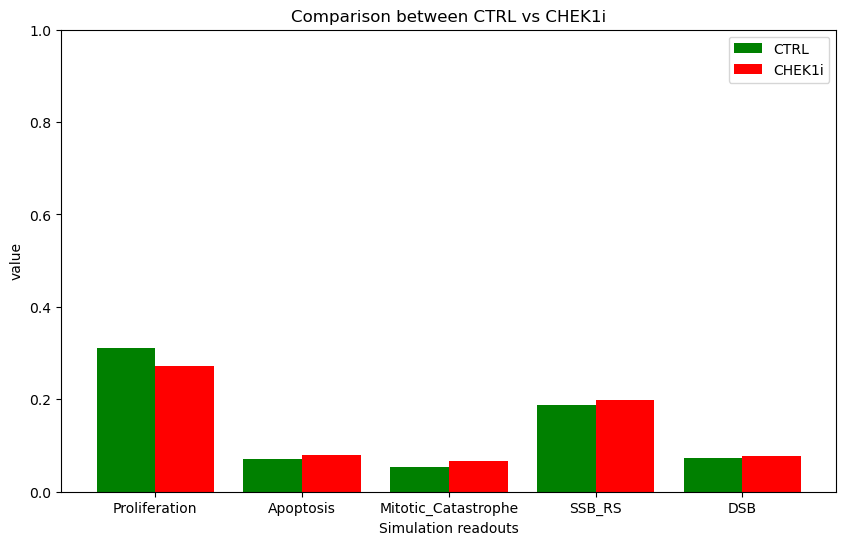

In [66]:
plt.figure(figsize=(10,6))

X = ['Proliferation','Apoptosis','Mitotic_Catastrophe','SSB_RS','DSB']
CTRL_data = list(WT_res.get_last_nodes_probtraj()[X].iloc[0,:])
CHEK1i_data = list(WT_res_chek1.get_last_nodes_probtraj()[X].iloc[0,:])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, CTRL_data, 0.4, label = 'CTRL',color = 'g')
plt.bar(X_axis + 0.2, CHEK1i_data, 0.4, label = 'CHEK1i', color = 'r')

plt.xticks(X_axis, X)
plt.xlabel("Simulation readouts")
plt.ylabel("value")
plt.ylim(0,1)
plt.title("Comparison between CTRL vs CHEK1i")
plt.legend()
plt.show()


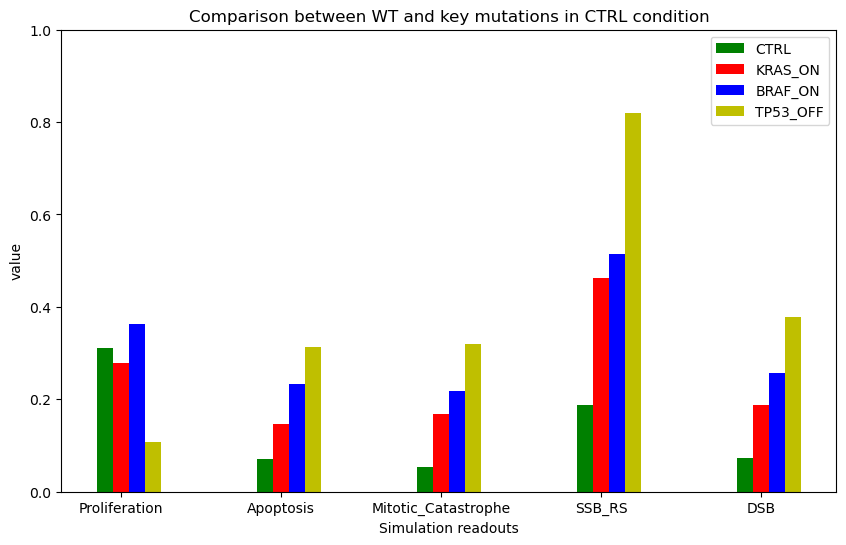

In [67]:
plt.figure(figsize=(10,6))

X = ['Proliferation','Apoptosis','Mitotic_Catastrophe','SSB_RS','DSB']
WT_data = list(WT_res.get_last_nodes_probtraj()[X].iloc[0,:])
KRAS_data = list(WT_KRAS_res.get_last_nodes_probtraj()[X].iloc[0,:])
BRAF_data = list(WT_BRAF_res.get_last_nodes_probtraj()[X].iloc[0,:])
TP53_data = list(WT_TP53_res.get_last_nodes_probtraj()[X].iloc[0,:])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.1, CTRL_data, 0.1, label = 'CTRL',color = 'g')
plt.bar(X_axis + 0.0, KRAS_data, 0.1, label = 'KRAS_ON', color = 'r')
plt.bar(X_axis + 0.1, BRAF_data, 0.1, label = 'BRAF_ON', color = 'b')
plt.bar(X_axis + 0.2, TP53_data, 0.1, label = 'TP53_OFF', color = 'y')

plt.xticks(X_axis, X)
plt.xlabel("Simulation readouts")
plt.ylabel("value")
plt.ylim(0,1)
plt.title("Comparison between WT and key mutations in CTRL condition")
plt.legend()
plt.show()

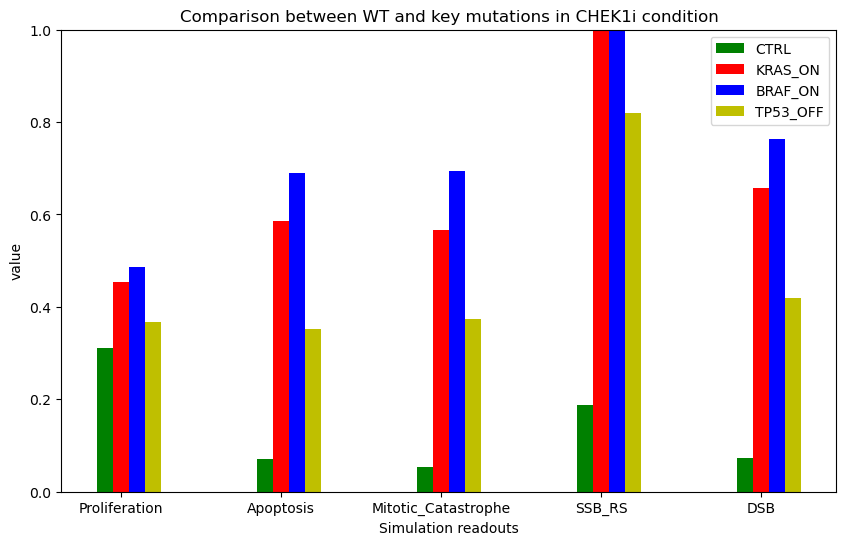

In [68]:
plt.figure(figsize=(10,6))

X = ['Proliferation','Apoptosis','Mitotic_Catastrophe','SSB_RS','DSB']
WT_data = list(WT_res_chek1.get_last_nodes_probtraj()[X].iloc[0,:])
KRAS_data = list(WT_KRAS_res_chek1.get_last_nodes_probtraj()[X].iloc[0,:])
BRAF_data = list(WT_BRAF_res_chek1.get_last_nodes_probtraj()[X].iloc[0,:])
TP53_data = list(WT_TP53_res_chek1.get_last_nodes_probtraj()[X].iloc[0,:])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.1, CTRL_data, 0.1, label = 'CTRL',color = 'g')
plt.bar(X_axis + 0.0, KRAS_data, 0.1, label = 'KRAS_ON', color = 'r')
plt.bar(X_axis + 0.1, BRAF_data, 0.1, label = 'BRAF_ON', color = 'b')
plt.bar(X_axis + 0.2, TP53_data, 0.1, label = 'TP53_OFF', color = 'y')

plt.xticks(X_axis, X)
plt.xlabel("Simulation readouts")
plt.ylabel("value")
plt.ylim(0,1)
plt.title("Comparison between WT and key mutations in CHEK1i condition")
plt.legend()
plt.show()

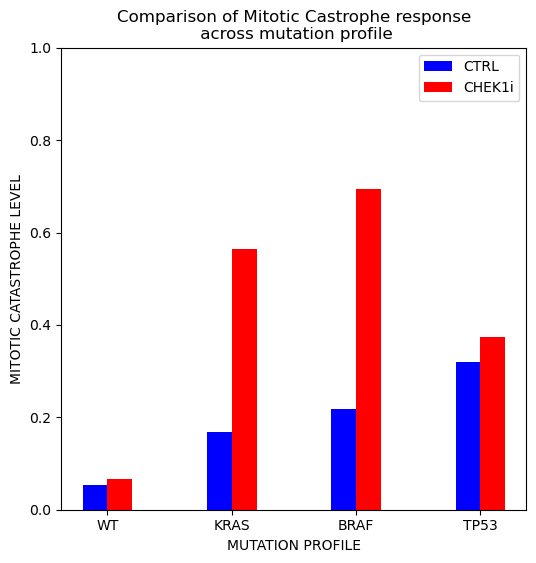

In [69]:
# MITOTIC CATSTROPHE IN ALL MUT PROFILE

plt.figure(figsize=(6,6))

X = ['WT','KRAS','BRAF','TP53']

CTRL_data = [WT_res.get_last_nodes_probtraj().Mitotic_Catastrophe[0],
             WT_KRAS_res.get_last_nodes_probtraj().Mitotic_Catastrophe[0],
             WT_BRAF_res.get_last_nodes_probtraj().Mitotic_Catastrophe[0],
             WT_TP53_res.get_last_nodes_probtraj().Mitotic_Catastrophe[0]]

CHEK1i_data = [WT_res_chek1.get_last_nodes_probtraj().Mitotic_Catastrophe[0],
               WT_KRAS_res_chek1.get_last_nodes_probtraj().Mitotic_Catastrophe[0],
               WT_BRAF_res_chek1.get_last_nodes_probtraj().Mitotic_Catastrophe[0],
               WT_TP53_res_chek1.get_last_nodes_probtraj().Mitotic_Catastrophe[0]]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.1, CTRL_data, 0.2, label = 'CTRL',color = 'b')
plt.bar(X_axis + 0.1, CHEK1i_data, 0.2, label = 'CHEK1i',color = 'r')

plt.xticks(X_axis, X)
plt.xlabel("MUTATION PROFILE")
plt.ylabel("MITOTIC CATASTROPHE LEVEL")
plt.ylim(0,1)
plt.title("Comparison of Mitotic Castrophe response\n across mutation profile")
plt.legend()
plt.show()



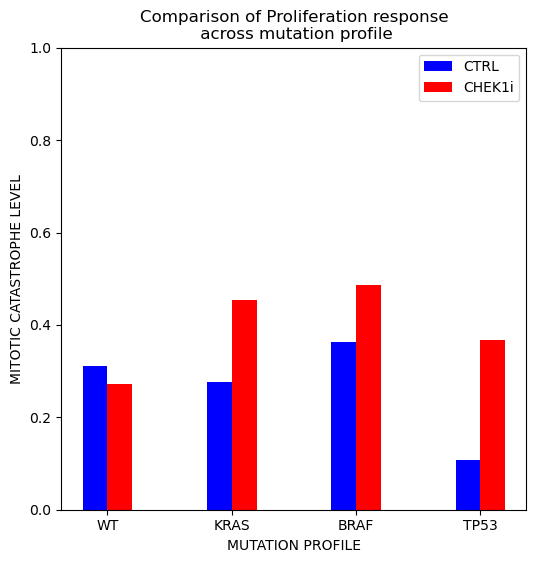

In [70]:
# MITOTIC CATSTROPHE IN ALL MUT PROFILE

plt.figure(figsize=(6,6))

X = ['WT','KRAS','BRAF','TP53']

CTRL_data = [WT_res.get_last_nodes_probtraj().Proliferation[0],
             WT_KRAS_res.get_last_nodes_probtraj().Proliferation[0],
             WT_BRAF_res.get_last_nodes_probtraj().Proliferation[0],
             WT_TP53_res.get_last_nodes_probtraj().Proliferation[0]]

CHEK1i_data = [WT_res_chek1.get_last_nodes_probtraj().Proliferation[0],
               WT_KRAS_res_chek1.get_last_nodes_probtraj().Proliferation[0],
               WT_BRAF_res_chek1.get_last_nodes_probtraj().Proliferation[0],
               WT_TP53_res_chek1.get_last_nodes_probtraj().Proliferation[0]]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.1, CTRL_data, 0.2, label = 'CTRL',color = 'b')
plt.bar(X_axis + 0.1, CHEK1i_data, 0.2, label = 'CHEK1i',color = 'r')

plt.xticks(X_axis, X)
plt.xlabel("MUTATION PROFILE")
plt.ylabel("MITOTIC CATASTROPHE LEVEL")
plt.ylim(0,1)
plt.title("Comparison of Proliferation response\n across mutation profile")
plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

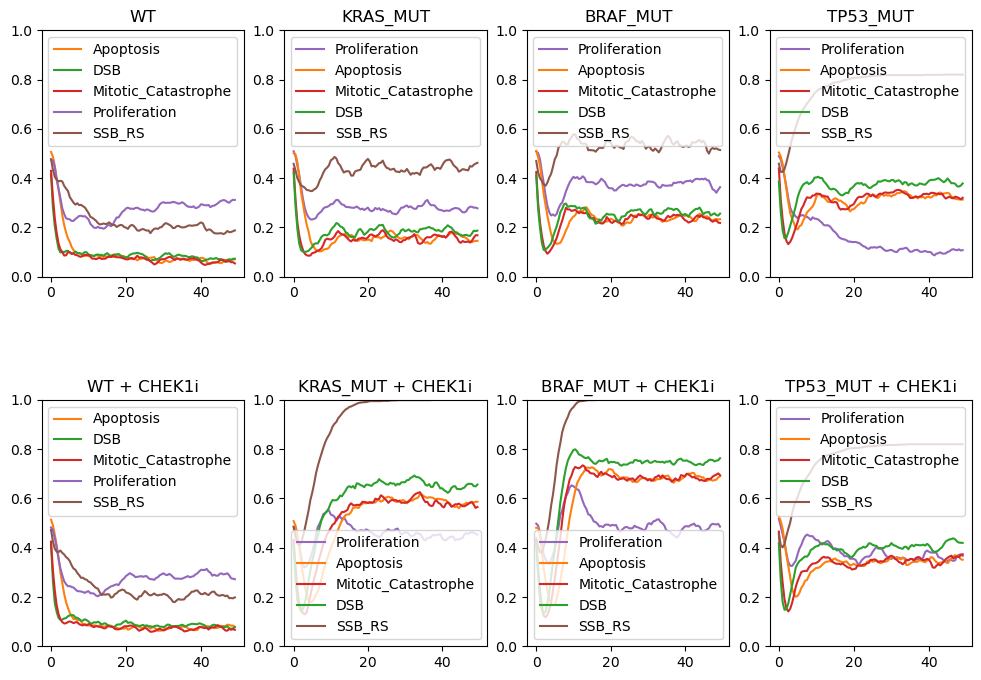

In [71]:
# Create plots

# Set up the axes with gridspec
import matplotlib.pyplot as plt

## define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)

# Plot WT
WT_res.plot_node_trajectory(axes = axs.ravel()[0])
axs[0][0].title.set_text("WT")
axs[0][0].set_ylim(0,1)

WT_KRAS_res.plot_node_trajectory(axes = axs.ravel()[1])
axs[0][1].title.set_text("KRAS_MUT")
axs[0][1].set_ylim(0,1)

WT_BRAF_res.plot_node_trajectory(axes = axs.ravel()[2])
axs[0][2].title.set_text("BRAF_MUT")
axs[0][2].set_ylim(0,1)

WT_TP53_res.plot_node_trajectory(axes = axs.ravel()[3])
axs[0][3].title.set_text("TP53_MUT")
axs[0][3].set_ylim(0,1)

# Plot CHEK1i
WT_res_chek1.plot_node_trajectory(axes = axs.ravel()[4])
axs[1][0].title.set_text("WT + CHEK1i")
axs[1][0].set_ylim(0,1)

WT_KRAS_res_chek1.plot_node_trajectory(axes = axs.ravel()[5])
axs[1][1].title.set_text("KRAS_MUT + CHEK1i")
axs[1][1].set_ylim(0,1)

WT_BRAF_res_chek1.plot_node_trajectory(axes = axs.ravel()[6])
axs[1][2].title.set_text("BRAF_MUT + CHEK1i")
axs[1][2].set_ylim(0,1)

WT_TP53_res_chek1.plot_node_trajectory(axes = axs.ravel()[7])
axs[1][3].title.set_text("TP53_MUT + CHEK1i")
axs[1][3].set_ylim(0,1)

plt.show()

In [77]:
## Set up the required files
bnd_file = model_name+".bnd"
cfg_WT = model_name+".bnd.cfg"

## Load MaBoSS model
WT = maboss.load(bnd_file, cfg_WT)

## modify the max_time if necessary
## select the variables considered to be internal (not appearing in the resulting csv file) 
## run the model for random initial conditions (defined in the cfg file) or from all 0s initial conditions 

WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':50})
WT_allinputs.update_parameters(sample_count = 1000,
                               thread_count = 10)

## By default, all variables are external (in the cfg file: Node.is_internal = FALSE). 
## If the model is big, the computations may take a very long time.
## We advise to set as external, only the variables that are relevant for the analysis

## if you wish to put some values as internal (the ones that will not be used for the analysis), write (uncomment):
#for name in "ERK_1_2 MK2 p38 Wee1 BRAF CDK1 p21 TP53 Proliferation Senescence Apoptosis".split(' '):
for name in "TAK1 PI3K MTORC2 CDC25A CDK4_6 S6 JNK AKT p38 p21".split(' '):
     WT_allinputs.network[name].is_internal = True


## Put all inputs at random
for i in WT_allinputs.network.names:
    WT_allinputs.network.set_istate(i,[0.5,0.5])

## Set all inputs at 0.5
WT_allinputs.network.set_istate('EGF',[0.5,0.5])
WT_allinputs.network.set_istate('TGFb',[0.5,0.5])
WT_allinputs.network.set_istate('TNF',[0.5,0.5])
WT_allinputs.network.set_istate('Wnt',[0.5,0.5])
WT_allinputs.network.set_istate('IL1R1',[0.5,0.5])
WT_allinputs.network.set_istate('IFNA',[0.5,0.5])
WT_allinputs.network.set_istate('DNA_damage_agent',[0.5,0.5])

####WT_allinputs.network.set_istate('GSK3B',[1,0])

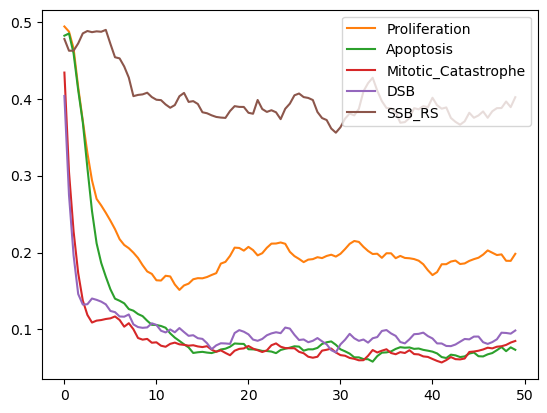

In [78]:
# Select outputs for visualisation of the results
WT_allinputs.network.set_output(('Proliferation','Apoptosis','Mitotic_Catastrophe',
                                 'DSB','SSB_RS'))

res = WT_allinputs.run()
res.plot_node_trajectory()